# Oscillation SNR

Topic: oscillations have variabile signal-to-noise ratio (SNR), which can complicate measurements. 

### Issue

Many measures of interest are implicitly dependent on the signal strength, or, effectively, the relative power, of the oscillations under study. This can also be though of as the signal-to-noise ratio of the data under study. If the power of the oscillation is low, then measures may be 'noisy', exhibiting high variability due a difficulty in resolving measurements.

### Solution

For analyses of interest, consider the required signal-to-noise ratio to get good measurements. Several strategies may be useful to optimize signal strength, including thing like using individualized frequency ranges to more specifically detect oscillations, and applying burst detection to any analyze data with rhythms present. In some cases, an amplitude threshold may be useful to select data of a high-enough magnitude for subsequent analyses. 

### Related Work

- [A robust statistical framework for instantaneous electroencephalogram phase and frequency estimation and analysis](https://doi.org/10.1088/1361-6579/aa93a1), Sameni & Seraj, 2017

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from fooof.utils import trim_spectrum
from fooof.plts.spectra import plot_spectra_shading

from neurodsp.sim import sim_oscillation, sim_powerlaw
from neurodsp.filt import filter_signal
from neurodsp.spectral import compute_spectrum
from neurodsp.timefrequency import amp_by_time, freq_by_time, phase_by_time
from neurodsp.utils import create_times, remove_nans, set_random_seed
from neurodsp.plts.time_series import plot_time_series, plot_instantaneous_measure

In [2]:
# Add path and import custom code for the project
import sys
sys.path.append('code')
from utils import phase_locking_value
from plts import plot_estimates, style_psd, savefig
from settings import ALPHA_RANGE, ALPHA_COLOR

## Settings

In [3]:
import seaborn as sns
sns.set_context('poster')

In [4]:
# Set random seed
set_random_seed(808)

In [5]:
# Set functions to use for averaging and variance
avg_func = np.nanmedian
var_func = np.nanvar

In [6]:
# Define general simulation settings
n_seconds = 25
fs = 1000
times = create_times(n_seconds, fs)

In [7]:
# Define parameters for the simulations
cf = 10
exp = -1.5
ap_filt = (3, 100)

# Define the relative powers to simulate
osc_powers = [0.01, 0.05, 0.1, 0.15, 0.25, 0.5]

In [46]:
# Set indices for example high & low power signals
HIGH_IND = -1
LOW_IND = 2

# Set inds for subselecting
inds = [0, 2, 5]

In [10]:
# Plot settings
xlim = [2.75, 4.5]
plt_clear = {'xlabel': '', 'ylabel': ''}

# Set color map for plotting the data
cmap = [plt.cm.Purples(ind) for ind in np.linspace(0.5, 0.9, len(osc_powers)+1)]
tcols = [cmap[ind+1] for ind in inds]

In [11]:
# Set whether to save out figures
SAVE_FIG = False

## Simulate Time Series

For this, we will simulate signals with oscillations of different relative powers. 

Note that the simulated data vary on relative power, but that the oscillations within each signal are themselves static and consistent. 

This means that any measured variability within the simulations necessarily stems from measurement issues.

In [12]:
# Create the aperiodic component
ap = sim_powerlaw(n_seconds, fs, exp, f_range=ap_filt, variance=0.5)

In [13]:
# Simulate signals across a range of oscillation powers, reflecting different SNRs
oscs, sigs = [], []
for osc_pow in osc_powers:

    # Simulate and collect the oscillation component
    osc = sim_oscillation(n_seconds, fs, cf, variance=osc_pow)
    oscs.append(osc)

    # Simulate and collect the combined signal
    sig = ap + osc
    sigs.append(sig)

### Plot the oscillation & full signal, across SNRs

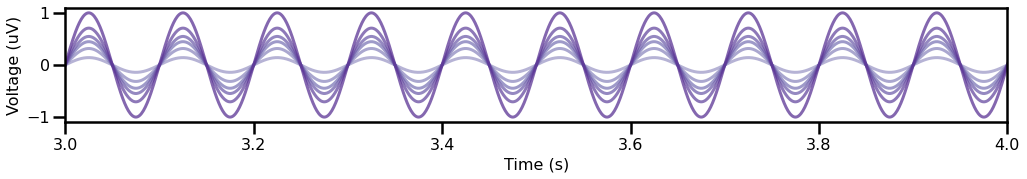

In [14]:
# Plot the simulated oscillations, across different amplitudes
plot_time_series(times, oscs, xlim=[3, 4], colors=cmap, alpha=0.75)

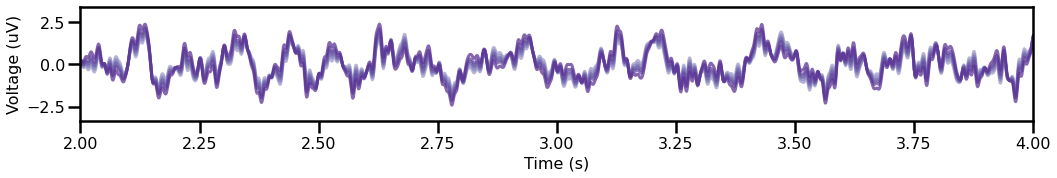

In [15]:
# Plot the simulated signals, when combined with aperiodic, across amplitudes
plot_time_series(times, sigs, xlim=[2, 4], colors=cmap, alpha=0.75)

### Compare the high and low SNR signals

In [17]:
# Extract a couple signals of interest
sig_high = sigs[HIGH_IND]
osc_high = oscs[HIGH_IND]

sig_low = sigs[LOW_IND]
osc_low = oscs[LOW_IND]

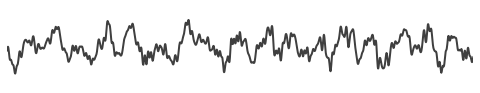

In [18]:
# Plot the time series of the high power signal
_, ax = plt.subplots(figsize=(8, 2.5))
plot_time_series(times, sig_high, lw=2, alpha=0.75,
                 xlim=xlim, ylim=[-3.5, 3.5], ax=ax)
plt.axis('off')
savefig(SAVE_FIG, '07-ts-highpow')

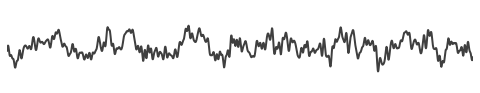

In [19]:
# Plot the time series of the low power signal
_, ax = plt.subplots(figsize=(8, 2.5))
plot_time_series(times, sig_low, lw=2, alpha=0.75, 
                 xlim=xlim, ylim=[-3.5, 3.5], ax=ax)
plt.axis('off')
savefig(SAVE_FIG, '07-ts-lowpow')

### Compute Power Spectra

In [20]:
# Calculate power spectra for each signal, across SNRs
pows = []
for sig in sigs:
    freqs, powers = trim_spectrum(*compute_spectrum(sig, fs, nperseg=1.5 * fs), (4, 35))
    pows.append(powers)

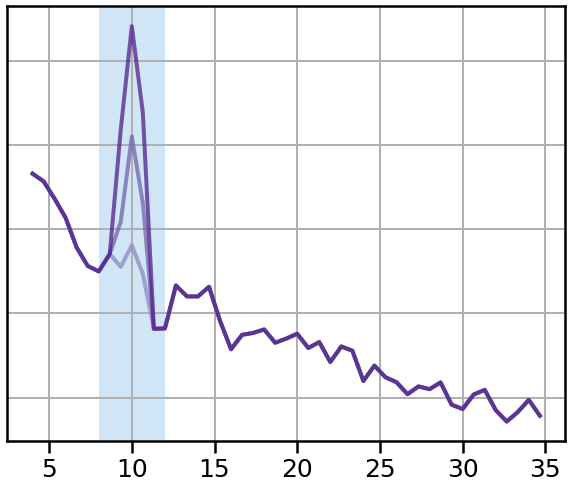

In [21]:
# Plot a sub-selection of signals
plot_spectra_shading(freqs, [pows[ind] for ind in inds], 
                     ALPHA_RANGE, ALPHA_COLOR, lw=4, log_powers=True)
style_psd(plt.gca(), line_colors=tcols, line_alpha=0.75)    
savefig(SAVE_FIG, '07-spectra_snrs')

## Compute Instantaneous Measures

Next, let's compute some instantaneous measures of interest on our signals. 

For these examples, we have added an alpha oscillations, so we will examine instantaneous measures of the alpha range. 

In [22]:
# Filter each signal, to the alpha range
sig_filt_high = filter_signal(sig_high, fs, 'bandpass', ALPHA_RANGE)
sig_filt_low = filter_signal(sig_low, fs, 'bandpass', ALPHA_RANGE)

In [23]:
# Compute instantaneous measures, for each signal
pha_high = phase_by_time(sig_filt_high, fs)
amp_high = amp_by_time(sig_filt_high, fs)
fre_high = freq_by_time(sig_filt_high, fs)

pha_low = phase_by_time(sig_filt_low, fs)
amp_low = amp_by_time(sig_filt_low, fs)
fre_low = freq_by_time(sig_filt_low, fs)

## Plot Instantaneous Measures

We can now plot our measures of interest, separately for the high and low power signals, and compare them. 

Recall that there is no temporal variability in the simulated oscillations. 

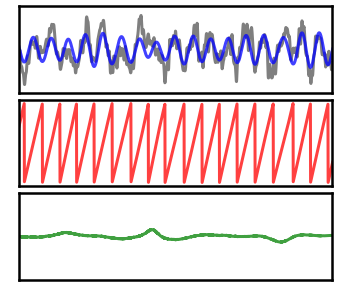

In [24]:
# Plot instantaneous measures for the high power signal
_, axes = plt.subplots(3, 1, figsize=(6, 5))
plot_time_series(times, [sig_high, sig_filt_high], ax=axes[0], 
                 alpha=[0.5, 0.75], colors=['k', 'b'],
                 xlim=xlim, ylim=[-3, 3], **plt_clear)
plot_instantaneous_measure(times, pha_high, 'phase', ax=axes[1],
                           alpha=[0.75], colors='r', xlim=xlim, **plt_clear)
plot_instantaneous_measure(times, fre_high, 'frequency',  ax=axes[2], 
                           alpha=[0.75], colors='g', 
                           xlim=xlim, ylim=[0, 20], **plt_clear)
for ax in axes: ax.set_xticks([]); ax.set_yticks([]);
plt.subplots_adjust(hspace=0.075)
savefig(SAVE_FIG, '07-measures-highpow')

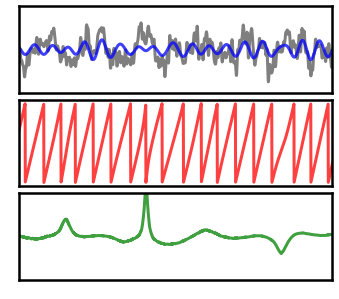

In [25]:
# Plot instantaneous measures for the low power signal
_, axes = plt.subplots(3, 1, figsize=(6, 5))
plot_time_series(times, [sig_low, sig_filt_low], ax=axes[0], 
                 colors=['k', 'b'], alpha=[0.5, 0.75], 
                 xlim=xlim, ylim=[-3, 3], **plt_clear)
plot_instantaneous_measure(times, pha_low, 'phase', ax=axes[1], 
                           alpha=0.75, colors=['r'], xlim=xlim, **plt_clear)
plot_instantaneous_measure(times, fre_low, 'frequency', ax=axes[2],
                           alpha=0.75, colors='g', 
                           xlim=xlim, ylim=[0, 20], **plt_clear)
for ax in axes: ax.set_xticks([]); ax.set_yticks([]);
plt.subplots_adjust(hspace=0.075)
savefig(SAVE_FIG, '07-measures-lowpow')

As we can see in the above plots and comparisons, there is much great measured variability in the low power signal. 

This variability does not accurately reflect the underlying signal, but rather is a limitation of the low power. 

## Compare Measures

In the above, we visually compared our measures. 

Next lets more quantitatively compare them, by computing descriptive statistics on the computed measures. 

In [26]:
# Set a buffer to ignore on the edges of the signal, for these comparisons
#   This is just a way to exclude any potential edge artifacts, from the filtering
buff = 1*fs

In [48]:
# Compute descriptive statistics of the high power signal
print('High Power Signal:')
print('  Amp - mean: {:+8.4f}, var: {:8.4f}'.format(\
    avg_func(amp_high[buff:-buff]), var_func(amp_high[buff:-buff])))
print('  Fre - mean: {:+8.4f}, var: {:8.4f}'.format(\
    avg_func(fre_high[buff:-buff]), var_func(fre_high[buff:-buff])))
# Compute descriptive statistics of the low power signal
print('Low Power Signal:')
print('  Amp - mean: {:+8.4f}, var: {:8.4f}'.format(\
    avg_func(amp_low[buff:-buff]), var_func(amp_low[buff:-buff])))
print('  Fre - mean: {:+8.4f}, var: {:8.4f}'.format(\
    avg_func(fre_low[buff:-buff]), var_func(fre_low[buff:-buff])))

High Power Signal:
  Amp - mean:  +1.0082, var:   0.0751
  Fre - mean:  +9.9995, var:   0.2774
Low Power Signal:
  Amp - mean:  +0.4952, var:   0.0530
  Fre - mean:  +9.8723, var:   2.9169


In the above measures, we see increased variability of the measures, in particular for frequency, and also for amplitude.

Note that the above comparison would not really make sense for phase, as it is a circular variable. 

Therefore, we can compare that one a little differently. For a consistent oscillation, the unwrapped phase should show consistent variation, which can be calculated as the differences between measured (unwrapped) phase values. 

For a more relevant measure for phase, let's check it's monotonicity. The unwrapped phase of ongoing oscillations should be monotonically increasing. However, in some cases, we can see 'phase slips', or a negative deflection of the measured (unwrapped) phase. The phase monotonicity, or lack thereof, is a measure of phase variability, whereby (for this case) higher values are more accurate.

In [65]:
# Compute unwrapped phase diffs for the high power signal
pha_high_uw = np.unwrap(remove_nans(pha_high[buff:-buff])[0])
pha_high_diffs = np.diff(pha_high_uw)

# Compute unwrapped phase diffs for the low power signal
pha_low_uw = np.unwrap(remove_nans(pha_low[buff:-buff])[0])
pha_low_diffs = np.diff(pha_low_uw)

In [66]:
# Comptute and compare the measured phase monotonicity of the signals
print('High Power - Phase monotonicity:  {:8.4f}'.format(\
    sum(pha_high_diffs >= 0) / len(pha_high_diffs)))
print('Low Power  - Phase monotonicity:  {:8.4f}'.format(\
    sum(pha_low_diffs >= 0) / len(pha_low_diffs)))

High Power - Phase monotonicity:    1.0000
Low Power  - Phase monotonicity:    0.9980


### Filtered Traces

In [67]:
# Filter and compute instantaneous phase of simulated signals
filts, phas = [], []
for sig in sigs:
    filt = filter_signal(sig, fs, 'bandpass', ALPHA_RANGE, remove_edges=False)
    filts.append(filt)    
    phas.append(phase_by_time(filt, fs))

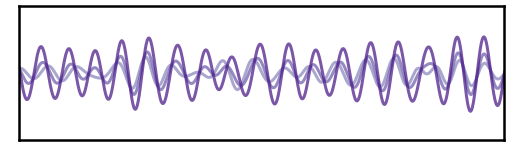

In [69]:
# Plot the filtered traces for sub-selected signals
_, ax = plt.subplots(figsize=(8, 3))
plot_time_series(times, [filts[ind] for ind in inds], colors=tcols,
                 xlim=xlim, alpha=0.75, **plt_clear, ax=ax)
ax.set_xticks([]); ax.set_yticks([]);
savefig(SAVE_FIG, '07-filters_snrs')

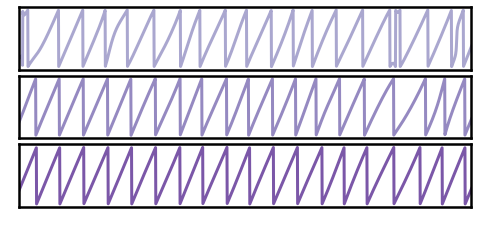

In [68]:
# Plot instantaneous phase for sub-selected signals
_, axes = plt.subplots(3, 1, figsize=(8, 4))
for ind, ax in enumerate(axes):
    plot_instantaneous_measure(times, phas[inds[ind]], 'phase', ax=ax,
                               xlim=[7.6, 9.5], alpha=0.75, **plt_clear, 
                               colors=tcols[ind])
for ax in axes: ax.set_xticks([]); ax.set_yticks([]);
plt.subplots_adjust(hspace=0.1)
savefig(SAVE_FIG, '07-phases_snrs')

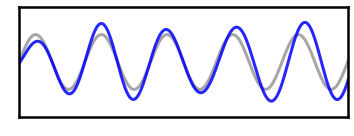

In [70]:
# Plot instantaneous measures for the high power signal
_, ax = plt.subplots(figsize=(6, 2.75))
plot_time_series(times, [osc_high, sig_filt_high], ax=ax, 
                 xlim=[2, 2.5], ylim=[-2, 2], **plt_clear, 
                 alpha=[0.35, 0.85], colors=['k', 'b'])
plt.xticks([]); plt.yticks([]);
savefig(SAVE_FIG, '07-tsfilt_high')

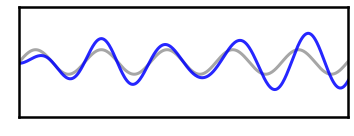

In [71]:
# Plot instantaneous measures for the low power signal
_, ax = plt.subplots(figsize=(6, 2.75))
plot_time_series(times, [osc_low, sig_filt_low], ax=ax, 
                 xlim=[2, 2.5], ylim=[-2, 2], **plt_clear, 
                 alpha=[0.35, 0.85], colors=['k', 'b'])
plt.xticks([]); plt.yticks([]);
savefig(SAVE_FIG, '07-tsfilt_low')

### Phase Consistency

Another way of looking at SNR is the consistency of estimations across multiple resamples. 

In this next analysis, we will resample multiple estimates of the high and low SNR signals, re-generating the aperiodic component that we add to the signal. 

Note that each sample uses the same oscillatory component, and therefore should have the same estimated instantaneous phase. Any variation across samples comes from estimation noise due to SNR. 

In [90]:
# Simulate multiple resamples of high and low SNR signals
n_sims = 10
phs_high, phs_low  = [], []
for ind in range(n_sims):

    ap = sim_powerlaw(n_seconds, fs, exp, ap_filt, variance=0.5)
    phs_high.append(phase_by_time(osc_high + ap, fs, ALPHA_RANGE))
    phs_low.append(phase_by_time(osc_low + ap, fs, ALPHA_RANGE))

phs_high = np.array(phs_high)
phs_low = np.array(phs_low)

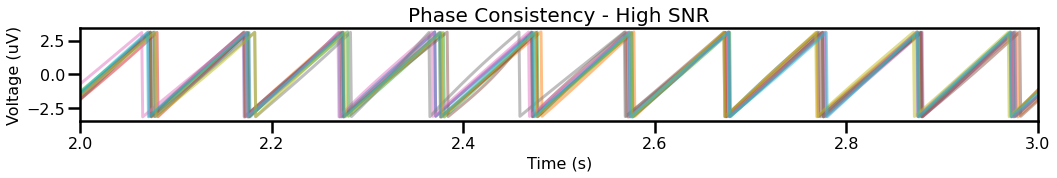

In [91]:
# Plot the instantaneous phase of multiple iterations of high power signals
plot_time_series(times, phs_high, xlim=[2, 3], alpha=0.5,
                 title='Phase Consistency - High SNR')

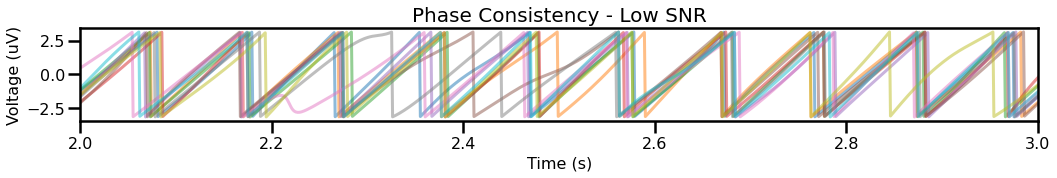

In [92]:
# Plot the instantaneous phase of multiple iterations of low power signals
plot_time_series(times, phs_low, xlim=[2, 3], alpha=0.5,
                 title='Phase Consistency - Low SNR')

In [93]:
# Calculate the true phase values from the high powered oscillation
true_phase = phase_by_time(osc_high, fs)

In [94]:
# Calculate the shading for the phase estimation
shd_high = np.nanstd(phs_high, 0)
shd_low = np.nanstd(phs_low, 0)

/Users/tom/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


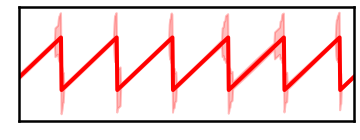

In [95]:
# Plot the distribution of estimated phase values for the high power signal
_, ax = plt.subplots(figsize=(6, 2.75))
plot_instantaneous_measure(times, true_phase, xlim=[2, 2.6],
                           colors='red', lw=4, ax=ax, **plt_clear)
plt.xticks([]); plt.yticks([]);
plt.fill_between(times, true_phase-shd_high, true_phase+shd_high, color='red', alpha=0.25)
savefig(SAVE_FIG, '07-pha_low')

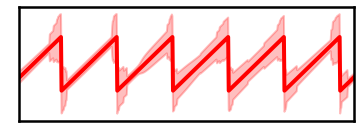

In [96]:
# Plot the distribution of estimated phase values for the low power signal
_, ax = plt.subplots(figsize=(6, 2.75))
plot_instantaneous_measure(times, true_phase, xlim=[2, 2.6], 
                           colors='red', lw=4, ax=ax, **plt_clear)
plt.xticks([]); plt.yticks([]);
plt.fill_between(times, true_phase-shd_low, true_phase+shd_low, color='red', alpha=0.25)
savefig(SAVE_FIG, '07-pha_high')

## Phase Locking Value

Finally, let's compare the phase locking value across the signals. 

Recall that all the oscillations have the same time course, and should therefore have equal phase locking. 

Differences in measured phase value therefore stem from different in SNR.

In [89]:
# Calculate the phase locking values across signals
plvs = []
pha_base = phas[-1]
for pha_comp in reversed(phas[:]):
    plvs.append(phase_locking_value(pha_base, pha_comp))

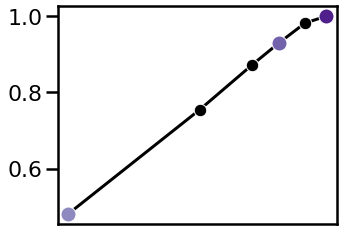

In [84]:
# Plot estimated PLV across oscillation strengths
plot_estimates(osc_powers, plvs, inds, tcols,
               xlim=(0.52, -0.01), figsize=(5, 4))
savefig(SAVE_FIG, '07-plvs_snrs')

## Conclusion

Neural signals can have different amounts of power of oscillatory components, creating different levels of signal-to-noise ratio, with respect to analyzing the oscillatory components of data. These differences in SNR can lead to estimation differences of values measures of interest. SNR should always be considered whenever estimating measures of interest, in order to determine if there is adequate SNR to adequately estimate the measure of interest, and whether differences or changes in SNR could influence any results. 